### Setup

In [1]:
pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 8.3 MB/s eta 0:00:00


### Define model

In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from deepxde.backend import tf

dde.backend.set_default_backend("tensorflow")

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


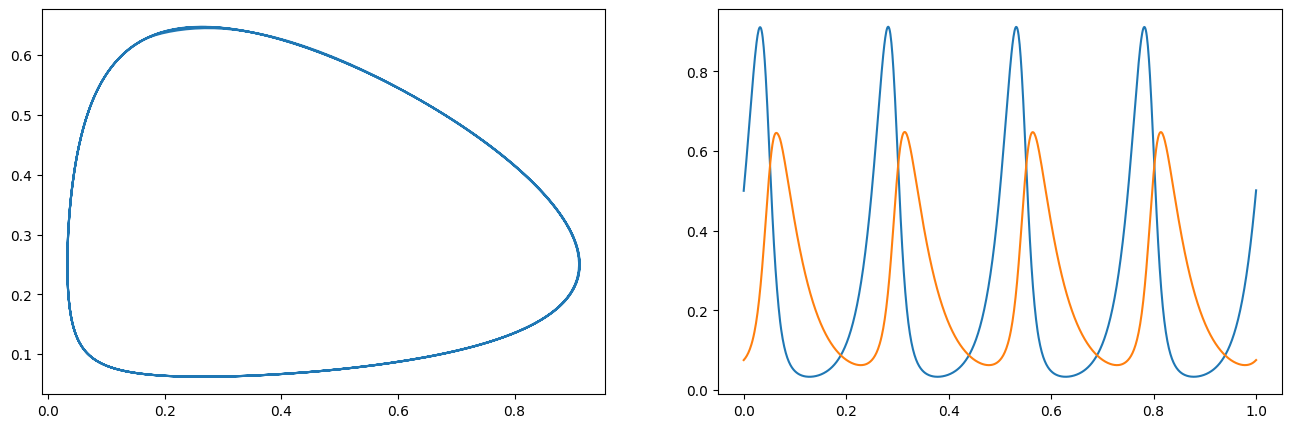

In [9]:
def lv_system(t, y):
    # There are two options for the ndarray y: It can either have shape (n,);
    # then fun must return array_like with shape (n,). Alternatively, it can
    # have shape (n, k); then fun must return an array_like with shape (n, k),
    # i.e., each column corresponds to a single column in y.
    # The choice between the two options is determined by vectorized argument
    # in scipy.integrate.solve_ivp
    r = y[0]
    p = y[1]

    ub = 200 # Upper bound
    rb = 20  # Right bound
    r_t = rb * (2.0 * r - 0.04 * r * ub * p)
    p_t = rb * (0.02 * r * ub * p - 1.06 * p)
    return r_t, p_t

def gen_truedata():
    t = np.linspace(0, 1, 1000)

    # Init cond: 100/ub, 15/ub

    sol = integrate.solve_ivp(lv_system, (0, 1), (100 / 200, 15 / 200), t_eval=t, method='DOP853')
    x_true, y_true = sol.y
    x_true = x_true.reshape(1000, 1)
    y_true = y_true.reshape(1000, 1)

    return x_true, y_true

x, y = gen_truedata()

fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(x,y)
ax[1].plot(np.linspace(0, 1, 1000),x)
ax[1].plot(np.linspace(0, 1, 1000),y)


In [52]:
def boundary(t, on_initial):
  return dde.utils.isclose(t, 0)

# Loss based IC
ic_r = dde.icbc.IC(timeInterval, lambda t: 100/200, boundary, component=0)
ic_p = dde.icbc.IC(timeInterval, lambda t: 15/200, boundary, component=1)

def lv_system_loss(t, y):

    r = y[:, 0:1]
    p = y[:, 1:2]
    r_t_nn = dde.grad.jacobian(r, t, i=0)
    p_t_nn = dde.grad.jacobian(p, t, i=0)

    ub = 200
    rb = 20
    r_t_system = rb * (2.0 * r - 0.04 * r * ub * p)
    p_t_system = rb * (0.02 * r * ub * p - 1.06 * p)

    loss_r = r_t_nn - r_t_system
    loss_p = p_t_nn - p_t_system

    return [loss_r, loss_p]


### Trial 1
Here we impose the **initial conditions through the loss function** and we employ the **time** as the input of the network.
  
We will train the model via the Adam optimizer for 35k iterations.  
  
You will se the model **failing**. Notably, the initial conditions are **not** respected in the solution, meaning that the corresponding loss term has been ignored.  

In [75]:
timeInterval = dde.geometry.TimeDomain(0, 1)
# No boundary conditions: we are using the PDE object, but the problem is actually a ODE
data = dde.data.PDE(timeInterval, lv_system_loss, [ic_r, ic_p], 3000, 2, num_test=3000)

In [76]:
# Neural Net architecture
layer_size = [1] + [64] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=35000)

Compiling model...
Building feed-forward neural network...
'build' took 0.065657 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.856866 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.63e-01, 2.95e+01, 2.50e-01, 5.63e-03]    [3.63e-01, 2.96e+01, 2.50e-01, 5.63e-03]    []  
1000      [6.01e-04, 1.22e-04, 2.49e-01, 5.38e-03]    [5.99e-04, 1.21e-04, 2.49e-01, 5.38e-03]    []  
2000      [9.25e-04, 1.77e-04, 2.48e-01, 5.33e-03]    [9.20e-04, 1.76e-04, 2.48e-01, 5.33e-03]    []  
3000      [1.58e-03, 1.63e-04, 2.48e-01, 5.41e-03]    [1.58e-03, 1.62e-04, 2.48e-01, 5.41e-03]    []  
4000      [9.09e-04, 8.02e-05, 2.48e-01, 5.44e-03]    [9.05e-04, 7.98e-05, 2.48e-01, 5.44e-03]    []  
5000      [8.23e-04, 6.76e-05, 2.48e-01, 5.47e-03]    [8.18e-04, 6.73e-05, 2.48e-01, 5.47e-03]    []  
6000      [8.71e-04, 8.11e-05, 2.48e-01, 5.44e-03]    [8.67e-04, 8.07e-05, 2.48e-01, 5.44e-03]    []  
7000      [7.78e-04, 2.14e-04, 2.48e-01, 5.45e-03]    [7.74e-04, 2.13e-04, 2.48e-01, 5.45e-03]    []  
8000      [7.29e-04,

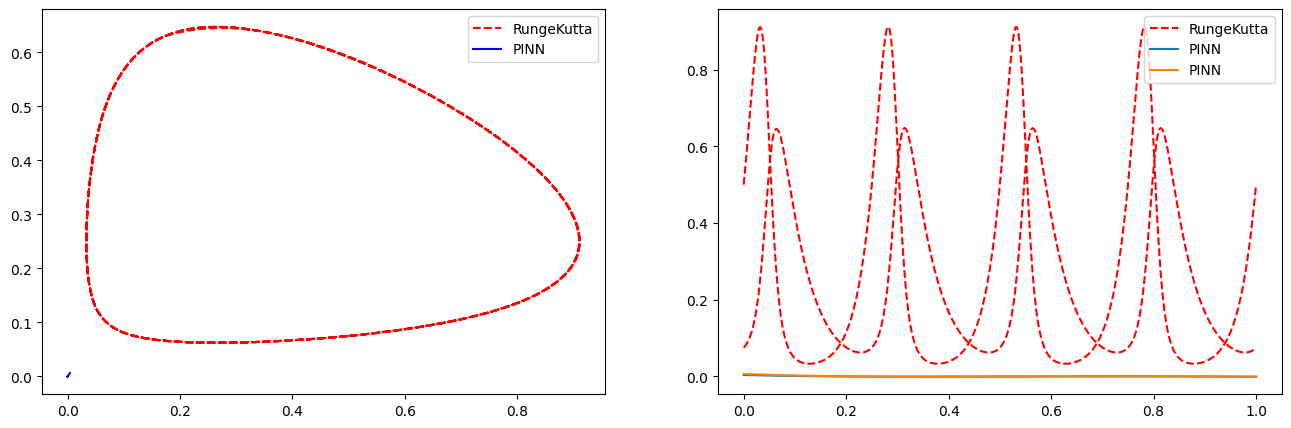

In [77]:
#dde.utils.external.plot_loss_history(losshistory)

t = np.linspace(0,1, 1000)
t = np.expand_dims(t, axis=1) # We need a tensor with the correct shape
pred = model.predict(t)
rPred = pred[:, 0]
pPred = pred[:, 1]

rTrue, pTrue = gen_truedata()

fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(rTrue, pTrue, 'r--', label="RungeKutta")
ax[0].plot(rPred, pPred, c='b', label="PINN")
ax[1].plot(t, pTrue, 'r--', label="RungeKutta")
ax[1].plot(t, rTrue, 'r--')
ax[1].plot(t, rPred, label="PINN")
ax[1].plot(t, pPred, label="PINN")
ax[0].legend()
_ = ax[1].legend()


## Hard constrain initial conditions

Here we impose the initial conditions through a different, stronger method. We still employ the time as the input of the network.  
  
For hard-constraining the initial condition we define an **output transform** which takes whatever output the network gives and multiplies it by a function which modifies the portion near to t=0.  
  
Then, such solution is used to compute the loss (that is only the loss due to the ODE system). Somehow, the network learns to deal with this.  
  
We train the model with 35K iterations of the Adam optimizer. the solution is not good, but the direction looks promising, so we sequentially recover the training with the LBFGS optimizer.
  
At iteration 41k, the LBFGS converges (its changes to the model are minimal) without having recovered the solution. The loss is of order 10e-03.


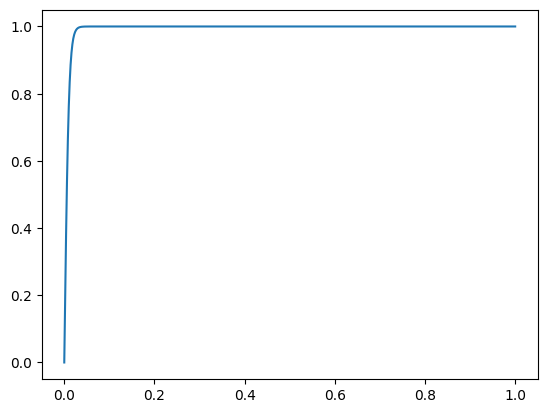

In [57]:
# Hard constrain the initial conditions
def output_transform(t, y):
    #
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]

    return tf.concat(
        [y1 * tf.tanh(100*t) + 100/200, y2 * tf.tanh(100*t) + 15/200],
        axis=1
    )

plt.plot(t, tf.tanh(t*100).eval(session=tf.compat.v1.Session()))


In [70]:
data = dde.data.PDE(timeInterval, lv_system_loss, [], 3000, 2, num_test=3000)

# Neural Net architecture
layer_size = [1] + [64] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
# Output transform imposes initial conditions
net.apply_output_transform(output_transform)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=35000)

Compiling model...
Building feed-forward neural network...
'build' took 0.074321 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.969028 s

Training model...

Step      Train loss              Test loss               Test metric
0         [9.03e+02, 6.58e+00]    [9.04e+02, 6.58e+00]    []  
1000      [2.34e+00, 2.57e+00]    [2.14e+00, 2.47e+00]    []  
2000      [7.86e-01, 1.58e+00]    [7.75e-01, 1.49e+00]    []  
3000      [7.20e-01, 1.11e+00]    [7.20e-01, 1.04e+00]    []  
4000      [2.17e-01, 3.32e-01]    [2.15e-01, 3.26e-01]    []  
5000      [2.15e-01, 2.28e-01]    [2.09e-01, 2.27e-01]    []  
6000      [1.61e-01, 2.49e-01]    [1.56e-01, 2.48e-01]    []  
7000      [1.50e-01, 2.53e-01]    [1.46e-01, 2.53e-01]    []  
8000      [1.61e-01, 2.20e-01]    [1.58e-01, 2.19e-01]    []  
9000      [1.60e-01, 1.73e-01]    [1.59e-01, 1.72e-01]    []  
10000     [1.45e-01, 1.58e-01]    [1.44e-01, 1.57e-01]    []  
11000     [1.50e-01, 1.54e-01]    [1.49e-01, 1.53e-01]    []  
12000     [9.13e-02, 1.42e-01]    [9.09e-02, 1.42e-01]    []  
13000     [8.82e-02, 1.36e-01]    [8.80e-02, 1.35e-01]    []  
14

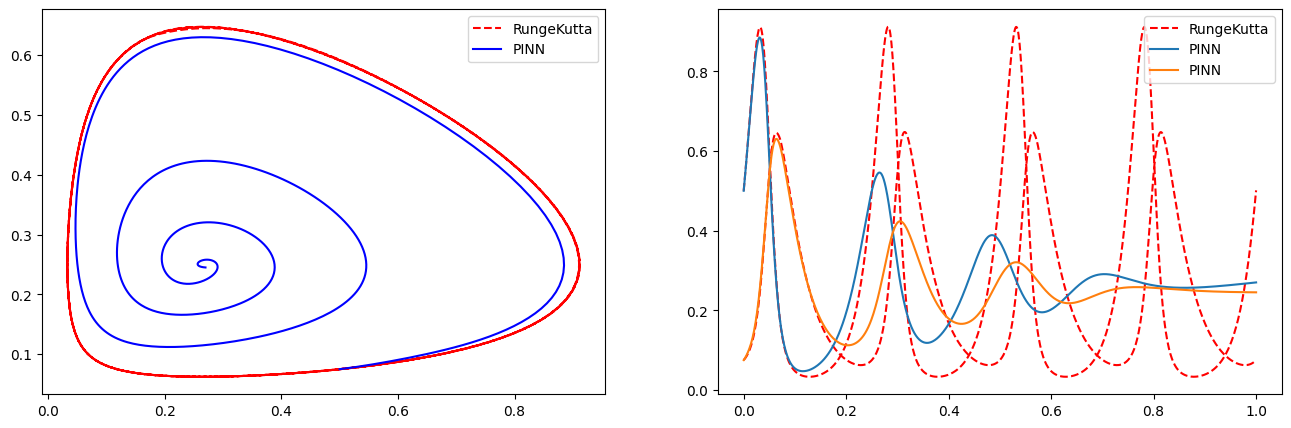

In [71]:
t = np.linspace(0,1, 1000)
t = np.expand_dims(t, axis=1)
pred = model.predict(t)
rPred = pred[:, 0]
pPred = pred[:, 1]

rTrue, pTrue = gen_truedata()

fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(rTrue, pTrue, 'r--', label="RungeKutta")
ax[0].plot(rPred, pPred, c='b', label="PINN")
ax[1].plot(t, pTrue, 'r--', label="RungeKutta")
ax[1].plot(t, rTrue, 'r--')
ax[1].plot(t, rPred, label="PINN")
ax[1].plot(t, pPred, label="PINN")
ax[0].legend()
_ = ax[1].legend()


In [72]:
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 1.424762 s

Training model...

Step      Train loss              Test loss               Test metric
35000     [3.39e-02, 5.25e-02]    [3.38e-02, 5.25e-02]    []  
36000     [2.80e-02, 4.18e-02]    [2.80e-02, 4.18e-02]        
37000     [2.04e-02, 3.82e-02]    [2.04e-02, 3.82e-02]        
38000     [1.40e-02, 2.68e-02]    [1.40e-02, 2.68e-02]        
39000     [5.99e-03, 1.20e-02]    [5.99e-03, 1.20e-02]        
40000     [3.56e-03, 5.61e-03]    [3.56e-03, 5.61e-03]        
41000     [1.72e-03, 2.18e-03]    [1.72e-03, 2.18e-03]        
41093     [1.66e-03, 2.12e-03]    [1.64e-03, 2.10e-03]    []  

Best model at step 41093:
  train loss: 3.77e-03
  test loss: 3.74e-03
  test metric: []

'train' took 793.975771 s



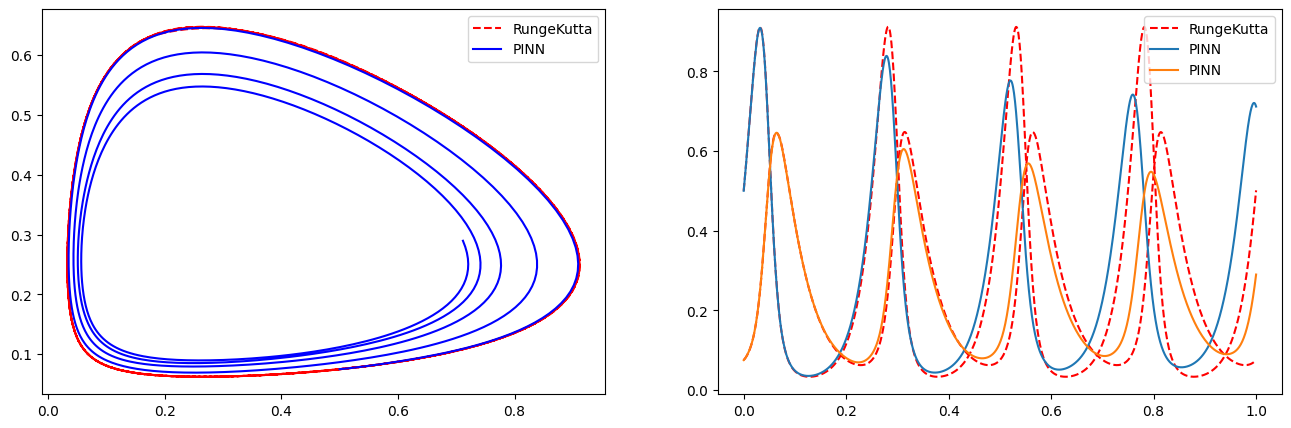

In [73]:
t = np.linspace(0,1, 1000)
t = np.expand_dims(t, axis=1)
pred = model.predict(t)
rPred = pred[:, 0]
pPred = pred[:, 1]

rTrue, pTrue = gen_truedata()

fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(rTrue, pTrue, 'r--', label="RungeKutta")
ax[0].plot(rPred, pPred, c='b', label="PINN")
ax[1].plot(t, pTrue, 'r--', label="RungeKutta")
ax[1].plot(t, rTrue, 'r--')
ax[1].plot(t, rPred, label="PINN")
ax[1].plot(t, pPred, label="PINN")
ax[0].legend()
_ = ax[1].legend()


## Hard constrain periodic solution

Here we impose the initial conditions through a hard-contraint.  
  
Additionally, we help the network by adding a **feature layer** at the beginning with features sin(kt): in such a way we constrain any solution it produces to be periodic. This can be regarded as a complementary and quite powerful way for introducing external knowledge on the system.

We train the model with 35K iterations of the Adam optimizer. As before, the solution is not good yet, but if we sequentially recover the training with the LBFGS optimizer we finally get very good results.

At iteration 37k (less than the previous model), the LBFGS converges to the true solution with loss in the order 10e-05.

In [60]:
def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2 * t),
            tf.sin(3 * t),
            tf.sin(4 * t),
            tf.sin(5 * t),
            tf.sin(6 * t)
        ),
        axis=1,
    )


In [66]:
net = dde.nn.FNN(layer_size, activation, initializer)
net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=35000)

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.222373 s

'compile' took 2.270151 s

Training model...

Step      Train loss              Test loss               Test metric
0         [7.55e+03, 4.59e+02]    [7.56e+03, 4.60e+02]    []  
1000      [8.25e-01, 1.95e+00]    [7.91e-01, 1.85e+00]    []  
2000      [7.37e-01, 1.45e+00]    [7.31e-01, 1.37e+00]    []  
3000      [7.38e-01, 1.26e+00]    [7.37e-01, 1.19e+00]    []  
4000      [6.87e-01, 1.11e+00]    [6.85e-01, 1.06e+00]    []  
5000      [6.11e-01, 1.03e+00]    [6.08e-01, 9.96e-01]    []  
6000      [5.02e-01, 8.24e-01]    [5.02e-01, 7.96e-01]    []  
7000      [3.41e-01, 1.95e-01]    [3.34e-01, 1.92e-01]    []  
8000      [2.10e-01, 1.39e-01]    [2.06e-01, 1.37e-01]    []  
9000      [2.40e-01, 1.46e-01]    [2.37e-01, 1.44e-01]    []  
10000     [1.66e-01, 1.33e-01]    [1.63e-01, 1.32e-01]    []  
11000     [1.95e-01, 1.16e-01]    [1.91e-01, 1.16e-01]    []  
12000     [1.55e-01, 1.39e-01]    [1.53e-01, 1.38e-01]    []  
13000     [1.82e-01, 1.34e-01]    [1.81e

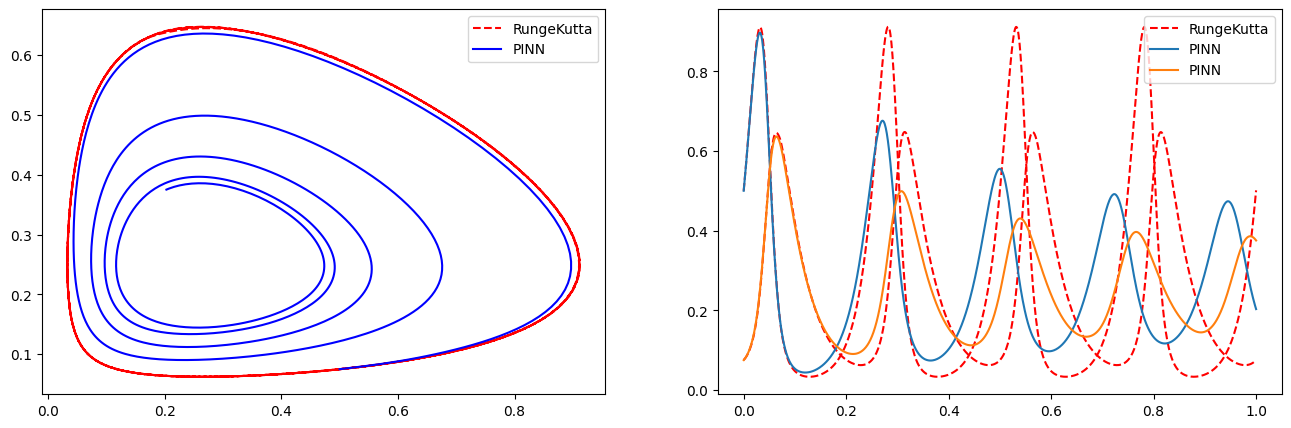

In [67]:
t = np.linspace(0,1, 1000)
t = np.expand_dims(t, axis=1)
pred = model.predict(t)
rPred = pred[:, 0]
pPred = pred[:, 1]

rTrue, pTrue = gen_truedata()

fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(rTrue, pTrue, 'r--', label="RungeKutta")
ax[0].plot(rPred, pPred, c='b', label="PINN")
ax[1].plot(t, pTrue, 'r--', label="RungeKutta")
ax[1].plot(t, rTrue, 'r--')
ax[1].plot(t, rPred, label="PINN")
ax[1].plot(t, pPred, label="PINN")
ax[0].legend()
_ = ax[1].legend()


In [68]:
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 1.125821 s

Training model...

Step      Train loss              Test loss               Test metric
35000     [6.28e-02, 2.33e-02]    [6.28e-02, 2.33e-02]    []  
36000     [1.38e-04, 2.51e-04]    [1.38e-04, 2.51e-04]        
37000     [2.94e-05, 3.85e-05]    [2.94e-05, 3.85e-05]        
37523     [1.45e-05, 2.63e-05]    [1.45e-05, 2.60e-05]    []  

Best model at step 37523:
  train loss: 4.09e-05
  test loss: 4.05e-05
  test metric: []

'train' took 296.576568 s



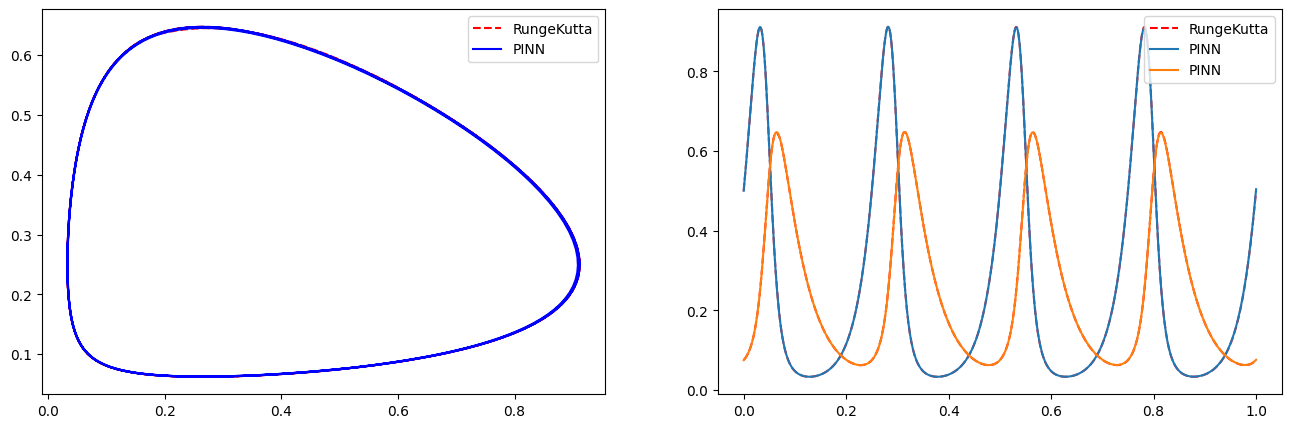

In [69]:
t = np.linspace(0,1, 1000)
t = np.expand_dims(t, axis=1)
pred = model.predict(t)
rPred = pred[:, 0]
pPred = pred[:, 1]

rTrue, pTrue = gen_truedata()

fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(rTrue, pTrue, 'r--', label="RungeKutta")
ax[0].plot(rPred, pPred, c='b', label="PINN")
ax[1].plot(t, pTrue, 'r--', label="RungeKutta")
ax[1].plot(t, rTrue, 'r--')
ax[1].plot(t, rPred, label="PINN")
ax[1].plot(t, pPred, label="PINN")
ax[0].legend()
_ = ax[1].legend()
